# Research Question

I want to find out whether income levels affect diabetes risk for African-American adults. This topic is important because diabetes affects this community at higher rates, and I want to see if income is one of the reasons why. 

I will use data from the NHANES 2021–2023 survey to compare diabetes measures across different income levels.

# Hypothesis

Null Hypothesis:
There is no difference in diabetes risk (HbA1c levels or diabetes diagnosis) between lower-income and higher-income African-American adults.

Alternative Hypothesis:
African-American adults with lower income have higher HbA1c levels and higher diabetes risk than those with higher income.

# Data Clean-up

I am using data from the CDC’s National Health and Nutrition Examination Survey (NHANES) from 2021–2023. I will use the following files:

●	Demographics (race, income, age, sex)
https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm

●	Glycohemoglobin (HbA1c biomarker)
https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/GHB_L.htm

●	Diabetes Questionnaire (self-reported diabetes)
https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DIQ_L.htm


   

In [23]:
# Import Libraries

import pandas as pd
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns


In [24]:
# Download NHANES Data

files = {
    "DEMO_L": "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.XPT",
    "GHB_L":  "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/GHB_L.XPT",
    "DIQ_L":  "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DIQ_L.XPT"
}

dataframes = {}

for name, url in files.items():
    print("Downloading:", name)
    r = requests.get(url)
    r.raise_for_status()

    df = pd.read_sas(BytesIO(r.content), format="xport")
    dataframes[name] = df

    print(f"{name} downloaded: {df.shape}")

demo = dataframes["DEMO_L"]
ghb  = dataframes["GHB_L"]
diq  = dataframes["DIQ_L"]


Downloading: DEMO_L
DEMO_L downloaded: (11933, 27)
Downloading: GHB_L
GHB_L downloaded: (7199, 3)
Downloading: DIQ_L
DIQ_L downloaded: (11744, 9)


In [25]:
# Merge Datasets

df = (
    demo
    .merge(ghb, on="SEQN", how="inner")
    .merge(diq, on="SEQN", how="inner")
)

df.shape


(7199, 37)

In [29]:
# Clean Data

missing_codes = [7, 9, 77, 99, 777, 999, 7777, 9999]
df = df.replace(missing_codes, np.nan)

columns_needed = [
    "SEQN", "RIAGENDR", "RIDAGEYR", "RIDRETH3", "INDFMPIR",
    "LBXGH", "DIQ010", "DIQ050"
]

columns_needed = [c for c in columns_needed if c in df.columns]
clean = df[columns_needed].copy()
clean.head()


,SEQN,RIAGENDR,RIDAGEYR,RIDRETH3,INDFMPIR,LBXGH,DIQ010,DIQ050
0,130378.0,1.0,43.0,6.0,5.00,5.6,2.0,NaN
1,130379.0,1.0,66.0,3.0,5.00,5.6,2.0,NaN
2,130380.0,2.0,44.0,2.0,1.41,6.2,1.0,2.0
3,130386.0,1.0,34.0,1.0,1.33,5.1,2.0,NaN
4,130387.0,2.0,68.0,3.0,1.32,5.9,2.0,NaN


In [33]:
# Convert Codes to Meaningful Labels

# Sex
clean["Sex"] = clean["RIAGENDR"].map({1: "Male", 2: "Female"})

# Race (NHANES RIDRETH3)
clean["Race"] = clean["RIDRETH3"].map({
    1: "Mexican American",
    2: "Other Hispanic",
    3: "Non-Hispanic White",
    4: "Non-Hispanic Black",
    6: "Non-Hispanic Asian",
    7: "Other"
})

# Diabetes diagnosis
clean["Diabetes"] = clean["DIQ010"].map({
    1: "Yes",
    2: "No",
    3: "Borderline"
})


In [35]:
# Focus on African-American Participants

aa = clean[clean["Race"] == "Non-Hispanic Black"].copy()
aa.shape


(915, 11)

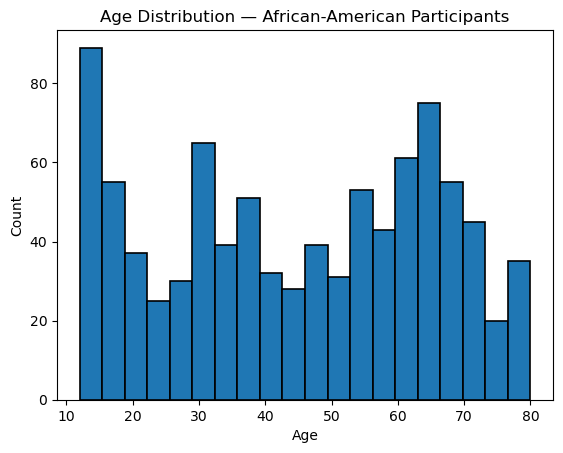

In [72]:
# Exploratory Analysis (Age Distribution)

plt.hist(aa["RIDAGEYR"].dropna(), bins=20, edgecolor="black", linewidth=1.2)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution — African-American Participants")
plt.show()


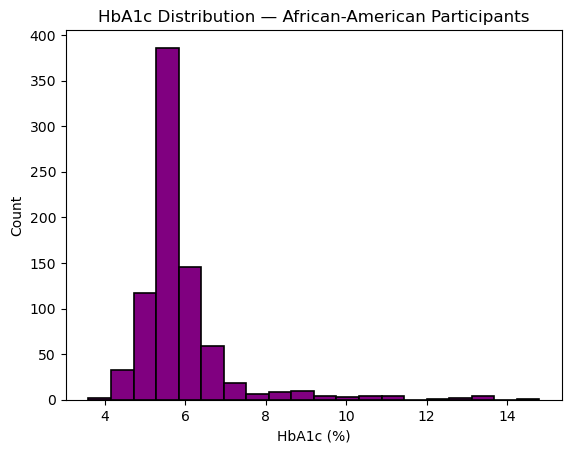

In [74]:
# Exploratory Analysis (HbA1c Distribution)

plt.hist(aa["LBXGH"].dropna(), bins=20, color="purple", edgecolor="black", linewidth=1.2)
plt.xlabel("HbA1c (%)")
plt.ylabel("Count")
plt.title("HbA1c Distribution — African-American Participants")
plt.show()


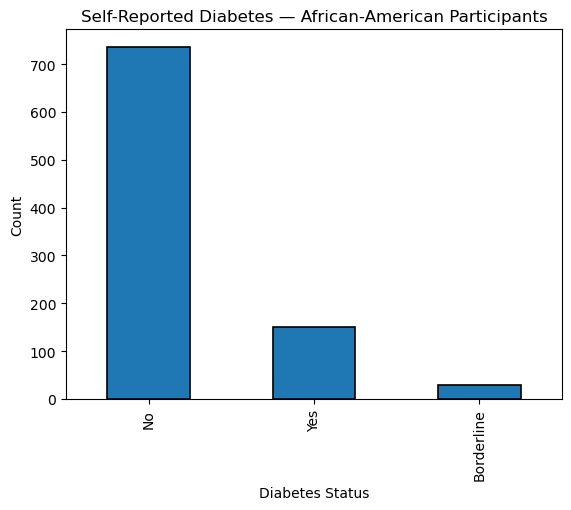

In [78]:
# Exploratory Analysis (Diabetes Prevalence)

aa["Diabetes"].value_counts().plot(
    kind="bar",
    edgecolor="black",
    linewidth=1.2
)

plt.title("Self-Reported Diabetes — African-American Participants")
plt.xlabel("Diabetes Status")
plt.ylabel("Count")
plt.show()



In [47]:
# Identify High-Risk Participants

def classify_hba1c(value):
    if pd.isna(value):
        return np.nan
    if value < 5.7:
        return "Normal"
    elif value < 6.5:
        return "Prediabetes"
    else:
        return "Diabetes"

aa["HbA1c_Status"] = aa["LBXGH"].apply(classify_hba1c)
aa["HbA1c_Status"].value_counts()

HbA1c_Status
Normal         419
Prediabetes    279
Diabetes       111
Name: count, dtype: int64

In [49]:
# Save Final Cleaned Dataset

aa.to_csv("AA_Diabetes_Cleaned.csv", index=False)


In [118]:

# Make a safe copy of aa
aa = aa.copy()

# If the Diabetes column doesn't exist or is numeric

if "Diabetes" not in aa.columns:
    aa["Diabetes"] = aa["DIQ010"].map({
        1: "Yes",
        2: "No",
        3: "Borderline"
    })

# Keep only adults with non-missing income & diabetes status

mask = aa["Diabetes"].isin(["Yes", "No"]) & aa["INDFMPIR"].notna()
df_perm = aa.loc[mask, ["INDFMPIR", "Diabetes"]].copy()

df_perm.head()


,INDFMPIR,Diabetes
5,0.81,No
24,1.02,No
28,0.11,Yes
52,5.00,No
61,5.00,No


# Diabetes rates vs Income

Observed difference (Yes - No): 0.14382443746376739
Permutation p-value: 0.3404


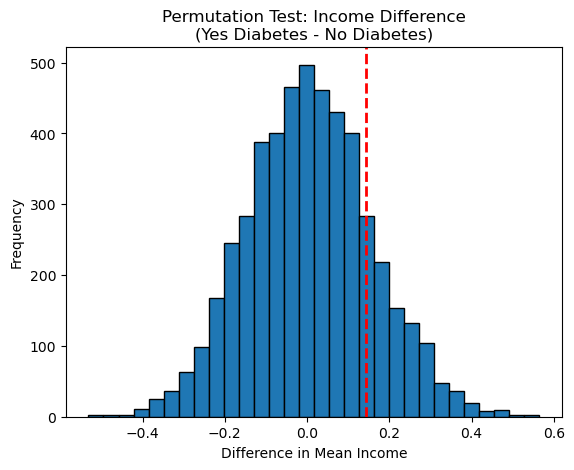

In [120]:
# Permuation Test

# Convert Diabetes to binary
df_perm["D"] = np.where(df_perm["Diabetes"] == "Yes", 1, 0)

# Observed difference in mean income
group_means = df_perm.groupby("D")["INDFMPIR"].mean()
obs_diff = group_means.loc[1] - group_means.loc[0]
print("Observed difference (Yes - No):", obs_diff)

# Permutation test
n_permutations = 5000
diffs = []

for i in range(n_permutations):
    permuted_labels = np.random.permutation(df_perm["D"])
    perm_means = df_perm.groupby(permuted_labels)["INDFMPIR"].mean()
    diff = perm_means.loc[1] - perm_means.loc[0]
    diffs.append(diff)

# p-value
p_value = np.mean(np.abs(diffs) >= np.abs(obs_diff))

print("Permutation p-value:", p_value)

# Plot Histogram

plt.hist(diffs, bins=30, edgecolor="black")
plt.axvline(obs_diff, color="red", linestyle="dashed", linewidth=2)
plt.title("Permutation Test: Income Difference\n(Yes Diabetes - No Diabetes)")
plt.xlabel("Difference in Mean Income")
plt.ylabel("Frequency")
plt.show()


Because the p-value is greater than 0.05, I do not have enough evidence to conclude that income levels are significantly different between adults with and without diabetes in this sample.

95% Bootstrap CI for (Yes - No) income difference:
-0.1532014980136486 0.455914820656568


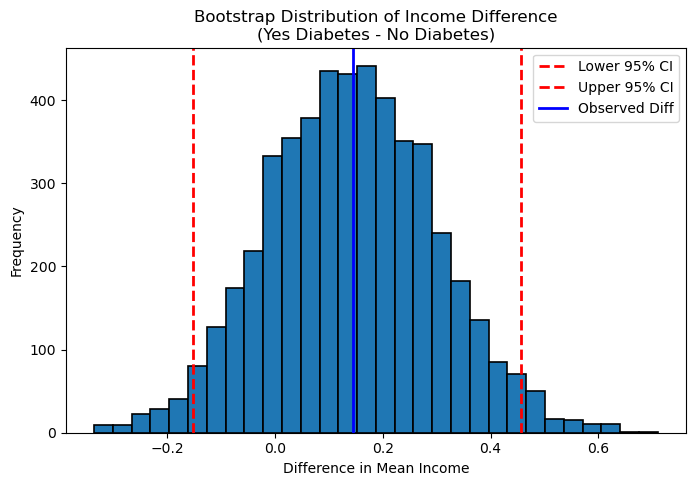

In [101]:
# Bootstrap Test

boot_diffs = []

for i in range(5000):
    sample = df_perm.sample(frac=1, replace=True)
    means = sample.groupby("D")["INDFMPIR"].mean()
    diff = means.loc[1] - means.loc[0]
    boot_diffs.append(diff)

ci_lower = np.percentile(boot_diffs, 2.5)
ci_upper = np.percentile(boot_diffs, 97.5)

print("95% Bootstrap CI for (Yes - No) income difference:")
print(ci_lower, ci_upper)

# Plot Histogram

plt.figure(figsize=(8,5))

plt.hist(boot_diffs, bins=30, edgecolor="black", linewidth=1.2)
plt.axvline(ci_lower, color="red", linestyle="dashed", linewidth=2, label="Lower 95% CI")
plt.axvline(ci_upper, color="red", linestyle="dashed", linewidth=2, label="Upper 95% CI")
plt.axvline(obs_diff, color="blue", linestyle="solid", linewidth=2, label="Observed Diff")

plt.title("Bootstrap Distribution of Income Difference\n(Yes Diabetes - No Diabetes)")
plt.xlabel("Difference in Mean Income")
plt.ylabel("Frequency")
plt.legend()
plt.show()



Interval includes 0, meaning the true difference could be negative, positive, or zero. There is no statistically significant income difference between diabetic and non-diabetic African-American adults.

# HbA1c vs Income

In [105]:
# Prepare the data

df_hba1c = aa.dropna(subset=["INDFMPIR", "LBXGH"]).copy()


In [107]:
# Correlation Test

corr = df_hba1c["INDFMPIR"].corr(df_hba1c["LBXGH"])
print("Correlation between Income and HbA1c:", corr)


Correlation between Income and HbA1c: 0.004126764907363091


Observed correlation: 0.004126764907363091
Permutation p-value: 0.9186


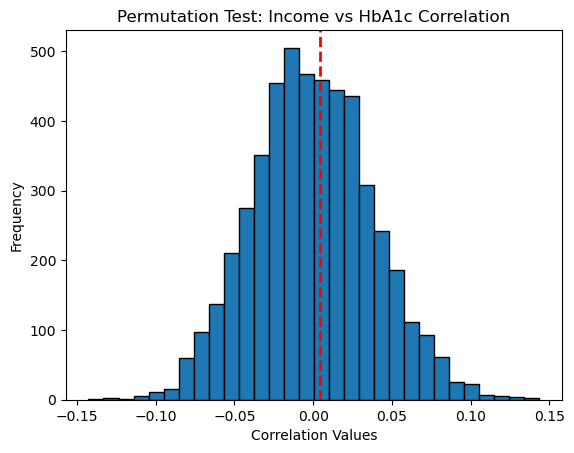

In [109]:
# Permutation Test

import numpy as np

# Observed correlation
obs_corr = df_hba1c["INDFMPIR"].corr(df_hba1c["LBXGH"])

# Permutation test
n_permutations = 5000
perm_corrs = []

for i in range(n_permutations):
    perm_income = np.random.permutation(df_hba1c["INDFMPIR"])
    corr = np.corrcoef(perm_income, df_hba1c["LBXGH"])[0,1]
    perm_corrs.append(corr)

p_value_corr = np.mean(np.abs(perm_corrs) >= np.abs(obs_corr))

print("Observed correlation:", obs_corr)
print("Permutation p-value:", p_value_corr)


# Plot Histogram

plt.hist(perm_corrs, bins=30, edgecolor="black")
plt.axvline(obs_corr, color="red", linestyle="dashed", linewidth=2)
plt.title("Permutation Test: Income vs HbA1c Correlation")
plt.xlabel("Correlation Values")
plt.ylabel("Frequency")
plt.show()


95% Bootstrap CI for correlation: (-0.05940536258107416, 0.07939466168303518)


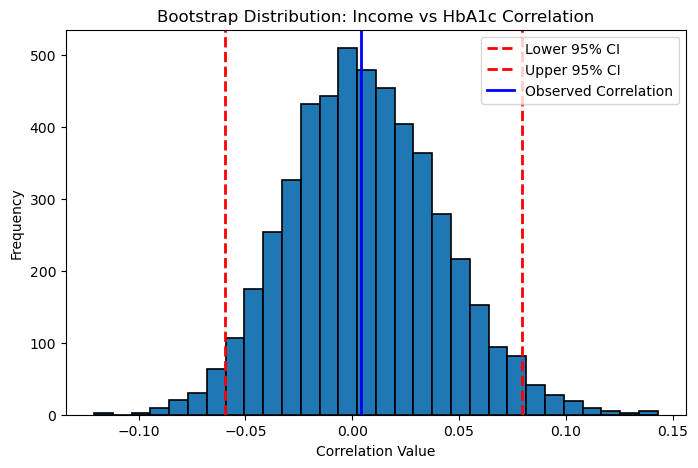

In [124]:
# Bootstrap Test

boot_corrs = []

for i in range(5000):
    sample = df_hba1c.sample(frac=1, replace=True)
    boot_corrs.append(sample["INDFMPIR"].corr(sample["LBXGH"]))

ci_lower = np.percentile(boot_corrs, 2.5)
ci_upper = np.percentile(boot_corrs, 97.5)

print("95% Bootstrap CI for correlation:", (ci_lower, ci_upper))

# Plot Histogram

plt.figure(figsize=(8,5))

plt.hist(boot_corrs, bins=30, edgecolor="black", linewidth=1.2)

plt.axvline(ci_lower, color="red", linestyle="dashed", linewidth=2, label="Lower 95% CI")
plt.axvline(ci_upper, color="red", linestyle="dashed", linewidth=2, label="Upper 95% CI")

plt.axvline(obs_corr, color="blue", linestyle="solid", linewidth=2, label="Observed Correlation")

plt.title("Bootstrap Distribution: Income vs HbA1c Correlation")
plt.xlabel("Correlation Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()



# Conclusion

My hypothesis proposed that African-American adults with lower income would have higher HbA1c levels and higher diabetes rates than those with higher income. To test the diabetes portion of this hypothesis, I compared income levels between individuals with and without diabetes using permutation and bootstrap tests. The observed income difference between the two groups was small, the permutation p-value was greater than 0.05, and the 95% bootstrap confidence interval included zero. These results show that there is no statistically significant difference in income between diabetic and non-diabetic participants, meaning income level did not predict diabetes status in this sample.
For the HbA1c portion of the hypothesis, I examined whether lower income was associated with higher HbA1c values using correlation, permutation, and bootstrap methods. The correlation measured the direction of the relationship, and the permutation and bootstrap tests were used to determine statistical significance. Based on these results, the income–HbA1c relationship was not strong or statistically significant, and the bootstrap confidence interval for the correlation included zero. This indicates that in this dataset, income level did not meaningfully predict HbA1c levels among African-American adults.
Overall, neither the diabetes results nor the HbA1c results provided evidence to support my original hypothesis. While socioeconomic factors often influence health outcomes, the NHANES 2021–2023 data for African-American adults did not show a significant relationship between income and diabetes risk or HbA1c levels. These findings suggest that income alone may not explain differences in diabetes-related health outcomes within this specific population sample.